In [1]:
import numpy as np
import time
from collections import namedtuple
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import qiskit as q
import qiskit.tools.jupyter
from qiskit.pulse import pulse_lib as _  # only want to call pulse_lib as q.pulse.pulse_lib

In [3]:
import pulse_compiler_helper_fns

In [4]:
q.IBMQ.load_account() # Load account from disk

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [5]:
provider = q.IBMQ.get_provider(group='qiskit-terra', project='pulse-testing')
backend = provider.get_backend('alt_almaden')
system = q.pulse.PulseChannelSpec.from_backend(backend)
config = backend.configuration()
cmd_def = q.pulse.CmdDef.from_defaults(backend.defaults().cmd_def, backend.defaults().pulse_library)
measure = cmd_def.get('measure', qubits=backend.configuration().meas_map[0])

/Users/alijavadi/Desktop/ajavadia-terra/qiskit/pulse/channels/pulse_channel_spec.py:87: DeprecationWarning: The PulseChannelSpec is deprecated. Use backend.configuration() instead. The supported methods require some migrations; check out the release notes for the complete details.
  DeprecationWarning)


In [6]:
beta = 3 * np.pi / 4
gamma = np.pi / 2

In [7]:
schedules = []

In [8]:
H = cmd_def.get('u2', qubits=[0], P0=0, P1=np.pi) | cmd_def.get('u2', qubits=[1], P0=0, P1=np.pi) | cmd_def.get('u2', qubits=[2], P0=0, P1=np.pi) | cmd_def.get('u2', qubits=[3], P0=0, P1=np.pi) | cmd_def.get('u2', qubits=[4], P0=0, P1=np.pi)

CNOT_RZ_CNOT_01 = cmd_def.get('cx', qubits=[0, 1])
CNOT_RZ_CNOT_01 |= cmd_def.get('u1', qubits=[1], P0=gamma) << CNOT_RZ_CNOT_01.duration
CNOT_RZ_CNOT_01 |= cmd_def.get('cx', qubits=[0, 1]) << CNOT_RZ_CNOT_01.duration

CNOT_RZ_CNOT_12 = cmd_def.get('cx', qubits=[1, 2])
CNOT_RZ_CNOT_12 |= cmd_def.get('u1', qubits=[2], P0=gamma) << CNOT_RZ_CNOT_12.duration
CNOT_RZ_CNOT_12 |= cmd_def.get('cx', qubits=[1, 2]) << CNOT_RZ_CNOT_12.duration

CNOT_RZ_CNOT_23 = cmd_def.get('cx', qubits=[2, 3])
CNOT_RZ_CNOT_23 |= cmd_def.get('u1', qubits=[3], P0=gamma) << CNOT_RZ_CNOT_23.duration
CNOT_RZ_CNOT_23 |= cmd_def.get('cx', qubits=[2, 3]) << CNOT_RZ_CNOT_23.duration

CNOT_RZ_CNOT_34 = cmd_def.get('cx', qubits=[3, 4])
CNOT_RZ_CNOT_34 |= cmd_def.get('u1', qubits=[4], P0=gamma) << CNOT_RZ_CNOT_34.duration
CNOT_RZ_CNOT_34 |= cmd_def.get('cx', qubits=[3, 4]) << CNOT_RZ_CNOT_34.duration

# RX(beta) = U3(beta, 3*pi/2, pi/2), hence line below
RX = cmd_def.get('u3', qubits=[0], P0=beta, P1=3*np.pi/2, P2=np.pi/2) | cmd_def.get('u3', qubits=[1], P0=beta, P1=3*np.pi/2, P2=np.pi/2) | cmd_def.get('u3', qubits=[2], P0=beta, P1=3*np.pi/2, P2=np.pi/2) | cmd_def.get('u3', qubits=[3], P0=beta, P1=3*np.pi/2, P2=np.pi/2) | cmd_def.get('u3', qubits=[4], P0=beta, P1=3*np.pi/2, P2=np.pi/2)

schedule = H
schedule |= CNOT_RZ_CNOT_01 << schedule.duration
schedule |= CNOT_RZ_CNOT_12 << schedule.duration
schedule |= CNOT_RZ_CNOT_23 << schedule.duration
schedule |= CNOT_RZ_CNOT_34 << schedule.duration
schedule |= RX << schedule.duration
schedule |= measure << schedule.duration

schedules.append(schedule)

In [9]:
## Optimized Way: zz_interaction decomposes directly to cross resonancefor theta in thetas:
circuit = q.QuantumCircuit(5)
circuit.h(0)
circuit.h(1)
circuit.h(2)
circuit.h(3)
circuit.h(4)

circuit.zz_interaction(gamma, 0, 1)
circuit.zz_interaction(gamma, 1, 2)
circuit.zz_interaction(gamma, 2, 3)
circuit.zz_interaction(gamma, 3, 4)

circuit.rx(beta, 0)
circuit.rx(beta, 1)
circuit.rx(beta, 2)
circuit.rx(beta, 3)
circuit.rx(beta, 4)

decomposed_circuit = circuit.decompose()

pulse_compiler_helper_fns.update_basis_gates_and_cmd_def(decomposed_circuit, backend, system, cmd_def)
transpiled_circuit = q.transpile(decomposed_circuit, backend, optimization_level=1)

schedule = q.schedule(transpiled_circuit, backend=backend, cmd_def=cmd_def)
schedule |= measure << schedule.duration
schedules.append(schedule)

In [11]:
shots = 8000
job = q.execute(schedules, backend=backend, shots=shots)
print('job is %s' % job.job_id())

job is 5dda0e668aa7e00018b8fc54


/anaconda3/lib/python3.6/site-packages/ipywidgets/widgets/widget_layout.py:84: DeprecationWarning: Layout properties overflow_x and overflow_y have been deprecated and will be dropped in a future release. Please use the overflow shorthand property instead
  warnings.warn("Layout properties overflow_x and overflow_y have been deprecated and will be dropped in a future release. Please use the overflow shorthand property instead", DeprecationWarning)


In [17]:
job.status()

<JobStatus.DONE: 'job has successfully run'>

# Run a mitigation cal job

In [36]:
import qiskit.ignis.mitigation.measurement as mit
meas_qcs, meas_labels = mit.complete_meas_cal(qubit_list=[0,1,2,3,4])
meas_qcs_transpiled = q.transpile(meas_qcs, backend, basis_gates=['x'])
meas_schedules = q.schedule(meas_qcs_transpiled, backend=backend, cmd_def=cmd_def)
job_mit = q.execute(meas_schedules, backend, shots=shots)

/anaconda3/lib/python3.6/site-packages/ipywidgets/widgets/widget_layout.py:84: DeprecationWarning: Layout properties overflow_x and overflow_y have been deprecated and will be dropped in a future release. Please use the overflow shorthand property instead
  warnings.warn("Layout properties overflow_x and overflow_y have been deprecated and will be dropped in a future release. Please use the overflow shorthand property instead", DeprecationWarning)


In [50]:
job_mit.status()

<JobStatus.DONE: 'job has successfully run'>

-----
## Analysis

In [51]:
from qiskit.result import marginal_counts

In [52]:
result = job.result()

In [53]:
# mitigate results
result_mit = marginal_counts(job_mit.result(), [0,1,2,3,4])
readout_fitter = mit.CompleteMeasFitter(result_mit, meas_labels)
readout_fitter.cal_matrix

array([[9.17125e-01, 7.68750e-02, 6.70000e-02, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [2.48750e-02, 8.66375e-01, 2.50000e-03, ..., 2.50000e-04,
        0.00000e+00, 1.25000e-04],
       [1.66250e-02, 1.87500e-03, 8.64000e-01, ..., 0.00000e+00,
        3.75000e-04, 1.25000e-04],
       ...,
       [0.00000e+00, 0.00000e+00, 0.00000e+00, ..., 6.97125e-01,
        1.75000e-03, 5.02500e-02],
       [0.00000e+00, 0.00000e+00, 0.00000e+00, ..., 1.75000e-03,
        7.05000e-01, 7.08750e-02],
       [0.00000e+00, 0.00000e+00, 0.00000e+00, ..., 1.00000e-02,
        2.01250e-02, 6.62250e-01]])

In [54]:
standard_counts = marginal_counts(result.get_counts(0), [0,1,2,3,4])
print('before mitigation:')
print(standard_counts)

standard_counts = readout_fitter.filter.apply(standard_counts)
print('\n\n\n after mitigation:')
print(standard_counts)

before mitigation:
{'00000': 164, '00001': 164, '00010': 336, '00011': 115, '00100': 519, '00101': 410, '00110': 233, '00111': 298, '01000': 321, '01001': 674, '01010': 606, '01011': 142, '01100': 144, '01101': 91, '01110': 333, '01111': 157, '10000': 194, '10001': 305, '10010': 692, '10011': 172, '10100': 397, '10101': 368, '10110': 127, '10111': 161, '11000': 86, '11001': 112, '11010': 59, '11011': 34, '11100': 187, '11101': 112, '11110': 150, '11111': 137}



 after mitigation:
{'00000': 73.94759199923955, '00001': 52.54881494049934, '00010': 246.61233017315266, '00011': 76.54636554893855, '00100': 502.98842129484694, '00101': 422.76416480593656, '00110': 181.1370116592928, '00111': 346.1019888084021, '01000': 245.57265258929428, '01001': 803.6477688297599, '01010': 702.1454816996077, '01011': 146.8753727776203, '01100': 110.75884864311479, '01101': 66.9421552034904, '01110': 382.8956728785569, '01111': 192.0042067884139, '10000': 85.34274306674088, '10001': 303.45093628342903, '100

In [55]:
optimized_counts = marginal_counts(result.get_counts(1), [0,1,2,3,4])
print('before mitigation:')
print(optimized_counts)

optimized_counts = readout_fitter.filter.apply(optimized_counts)
print('\n\n\n after mitigation:')
print(optimized_counts)

before mitigation:
{'00000': 117, '00001': 390, '00010': 189, '00011': 70, '00100': 97, '00101': 198, '00110': 275, '00111': 90, '01000': 149, '01001': 671, '01010': 480, '01011': 96, '01100': 218, '01101': 371, '01110': 431, '01111': 198, '10000': 197, '10001': 337, '10010': 758, '10011': 213, '10100': 250, '10101': 873, '10110': 274, '10111': 110, '11000': 84, '11001': 294, '11010': 80, '11011': 41, '11100': 58, '11101': 101, '11110': 218, '11111': 72}



 after mitigation:
{'00000': 64.31836727224682, '00001': 342.48789420516823, '00010': 88.92461530463044, '00011': 46.18446098380638, '00100': 41.71832442734677, '00101': 118.13220927356623, '00110': 250.63734268255885, '00111': 73.88916755483336, '01000': 48.20881623716803, '01001': 763.0900811585608, '01010': 542.621438365874, '01011': 82.86262196968067, '01100': 189.37167982351284, '01101': 439.99231512975155, '01110': 502.7120907277713, '01111': 252.68151359864967, '10000': 98.22639233689812, '10001': 263.68596468088134, '10010':

In [56]:
# sanitize data and plot
for key in standard_counts:
    standard_counts[key] = int(standard_counts[key])
for key in optimized_counts:
    optimized_counts[key] = int(optimized_counts[key])

In [57]:
standard_counts

{'00000': 73,
 '00001': 52,
 '00010': 246,
 '00011': 76,
 '00100': 502,
 '00101': 422,
 '00110': 181,
 '00111': 346,
 '01000': 245,
 '01001': 803,
 '01010': 702,
 '01011': 146,
 '01100': 110,
 '01101': 66,
 '01110': 382,
 '01111': 192,
 '10000': 85,
 '10001': 303,
 '10010': 791,
 '10011': 179,
 '10100': 401,
 '10101': 413,
 '10110': 87,
 '10111': 187,
 '11000': 70,
 '11001': 124,
 '11010': 46,
 '11011': 26,
 '11100': 218,
 '11101': 131,
 '11110': 184,
 '11111': 194}

In [58]:
optimized_counts

{'00000': 64,
 '00001': 342,
 '00010': 88,
 '00011': 46,
 '00100': 41,
 '00101': 118,
 '00110': 250,
 '00111': 73,
 '01000': 48,
 '01001': 763,
 '01010': 542,
 '01011': 82,
 '01100': 189,
 '01101': 439,
 '01110': 502,
 '01111': 252,
 '10000': 98,
 '10001': 263,
 '10010': 849,
 '10011': 234,
 '10100': 179,
 '10101': 1069,
 '10110': 273,
 '10111': 111,
 '11000': 62,
 '11001': 367,
 '11010': 66,
 '11011': 39,
 '11100': 38,
 '11101': 112,
 '11110': 291,
 '11111': 93}

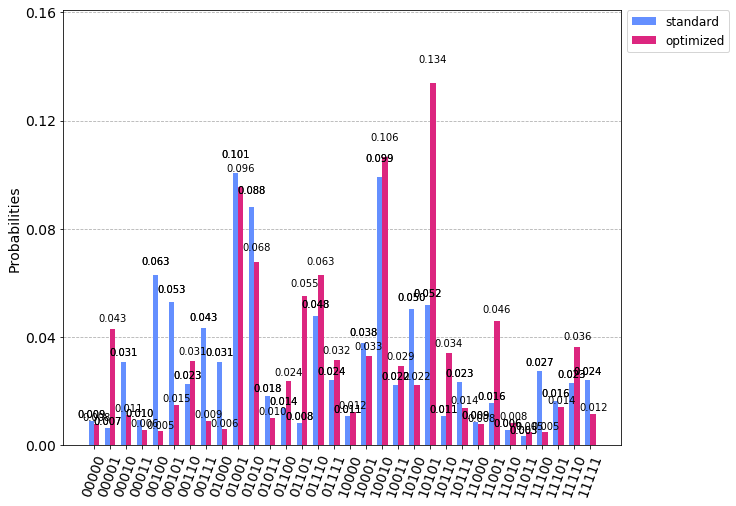

In [59]:
from qiskit.visualization import plot_histogram
plot_histogram([standard_counts, optimized_counts], legend=['standard', 'optimized'], figsize=(10,8))

In [ ]:
# ideal_counts = {'01': 4000, '10': 4000}
# standard_counts = {'00': 9.306905529044516e-10, '01': 4340.499596429236, '10': 3659.5004035698817}
# optimized_counts = {'00': 3.2117147307346117e-09, '01': 4201.575210406215, '10': 3798.4247895903336, '11': 2.401224165590816e-10}

In [ ]:
# print(pulse_compiler_helper_fns.kl_divergence(ideal_counts, standard_counts))
# print(pulse_compiler_helper_fns.kl_divergence(ideal_counts, optimized_counts))

In [ ]:
# print(pulse_compiler_helper_fns.cross_entropy(ideal_counts, standard_counts))
# print(pulse_compiler_helper_fns.cross_entropy(ideal_counts, optimized_counts))